In [2]:
import requests
from bs4 import BeautifulSoup as bf
import pandas as pd
import numpy as np
import codecs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
from selenium.webdriver.support.ui import Select
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
from collections import Counter

%matplotlib inline

# Scrapping the Dylan Lyrics

In [ ]:
url = 'http://lyrics.wikia.com/wiki/Bob_Dylan'

data = bf(requests.get(url).text)

url_lst = []
for  ols in data.find_all('ol'):
    try:
        for ol in ols:
            url_lst.append('http://lyrics.wikia.com' + ol.a.get('href'))
    except:
        pass
    
dylan = []
for url in url_lst:
    temp_dic = {}
    try:
        soup = bf(requests.get(url).text)
        temp_dic['title'] = soup.find('div', id = 'song-header-title').text.strip()
        temp_dic['lyrics'] = ' '.join([a for a in re.split(r'([A-Z][a-z]*)', soup.find('div', class_ = 'lyricbox').text) if a]).replace('\n', '')
        temp_dic['album'] = soup.find('i').text.split('(')[0].strip().replace(')', '')
        temp_dic['release_date'] = soup.find('i').text.split('(')[1].strip()
        dylan.append(temp_dic)
    except:
        pass


In [ ]:
# Making a data frame
dylan_df = pd.DataFrame({'song': [i['title'] for i in dylan],
                        'album': [i['album'] for i in dylan],
                        'release_date': [int(i['release_date'].split(')')[0]) for i in dylan],
                        'lyrics': [i['lyrics'] for i in dylan]})
dylan_df['dylan_age'] = dylan_df.release_date - 1941
dylan_df = dylan_df[['song', 'album','dylan_age' ,'release_date', 'lyrics']]

In [ ]:
dylan_df[['song', 'album', 'dylan_age', 'release_date', 'lyrics']].to_pickle('dylan_info_df.pkl')

In [27]:
dylan_df = pd.read_pickle('dylan_info_df.pkl')
dylan_df = dylan_df[dylan_df.album != 'Christmas In The Heart'].reset_index(drop = True)

It's a small data set of only 413 songs

In [28]:
dylan_df.head()

,song,album,dylan_age,release_date,lyrics
0,You're No Good,Bob Dylan,21,1962,"Well , I don't know why I love you like I..."
1,Talkin' New York,Bob Dylan,21,1962,Ramblin ' out of the wild West Leavin ' the t...
2,In My Time Of Dyin',Bob Dylan,21,1962,"Well , in my time of dyin' Don 't want nobody ..."
3,Man of Constant Sorrow,Bob Dylan,21,1962,I am a man of constant sorrow I 've seen trou...
4,Fixin' to Die,Bob Dylan,21,1962,"Feeling funny in my mind, Lord I believe I..."


In [32]:
# Take out the instrumental tracks
instrumental_index = []
for i,song in enumerate(dylan_df.lyrics):
    if 'Instrumental' in song:
        instrumental_index.append(i)

# Exclude the greatest hits        
greatest_hits_index = []
for i,song in enumerate(dylan_df.album):
    if 'Greatest' in song:
        greatest_hits_index.append(i)


# Take out albums that have less than 4 songs, they tend
#to be soundtracks
by_album = dylan_df.groupby('album').count()
true_albums = []
for i in range(by_album.shape[0]):
    if by_album.song[i] > 4:
        true_albums.append(by_album.index[i])
        
album_indexes = []
for i, album_name in enumerate(dylan_df.album):
    if album_name in true_albums:
        album_indexes.append(i)
        


dylan_df = dylan_df.copy().loc[set(album_indexes) - set(instrumental_index + greatest_hits_index)].reset_index(drop= True)

In [33]:
"The Clean data set is %r songs long"%dylan_df.shape[0]

'The Clean data set is 393 songs long'

## Topic Modeling

In [34]:
# Creating the Stopword list
import nltk

stopwords = [i for i in nltk.corpus.stopwords.words('english')]
stopwords += ['said', 'like', 'may', 'oh', 'well']

### Vectorize Dylan's Lyrics

In [35]:
# Vectorizing the Lyrics
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words = stopwords,
                     min_df = .05,
                     max_df = .85)

tfidf = tfidf_vect.fit_transform(dylan_df.lyrics)
tfidf_feature_names = tfidf_vect.get_feature_names()

### Topic Modeling: NMF

In [114]:
from sklearn.decomposition import NMF

nmf = NMF(n_components = 5, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
transformed_data = nmf.transform(tfidf)

In [115]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic:" + str(int(topic_idx)+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_top_words(nmf, tfidf_feature_names, 20)

Topic:1
love know got time see go say night never heart way get come day could back let still tell away
Topic:2
baby come please honey got dream mind wrong know wanna door last something good long die want really get look
Topic:3
lord yes hand die got blood hold heaven want woman keep gone world door feel believe bound ground train mama
Topic:4
gonna take make got everybody easy boy hard things says somebody keep woman let soul good tonight big day hands
Topic:5
man one little took god woman went name done lookin back stand hand take run first get come king right


In [116]:
topics = {1:'Love',
         2: 'Pleading to a Lover',
         3: 'God',
         4: 'Troubles',
         5: 'Other'}

In [139]:
final_data = pd.DataFrame(transformed_data).applymap(lambda x: 1 if x>0.05 else 0)
final_data.columns = topics.values()
final_data['year'] = [i for i in dylan_df.release_date]

by_year = final_data.groupby('year').sum()
for i in by_year.index:
    by_year.loc[i] = by_year.loc[i]/float(np.sum(by_year.loc[i]))

# Visualizations

In [140]:
pd.DataFrame(tfidf.todense(), columns = [tfidf_feature_names]).describe().loc['mean'].sort_values(ascending = False).head()


know    0.053485
love    0.053221
got     0.052596
one     0.050351
baby    0.043644
Name: mean, dtype: float64

In [141]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 25, 'font.size': 25, 'legend.fontsize': 35.0,
    'axes.titlesize': 20, "figure.figsize": [35, 14]}
sns.set(rc = rc)

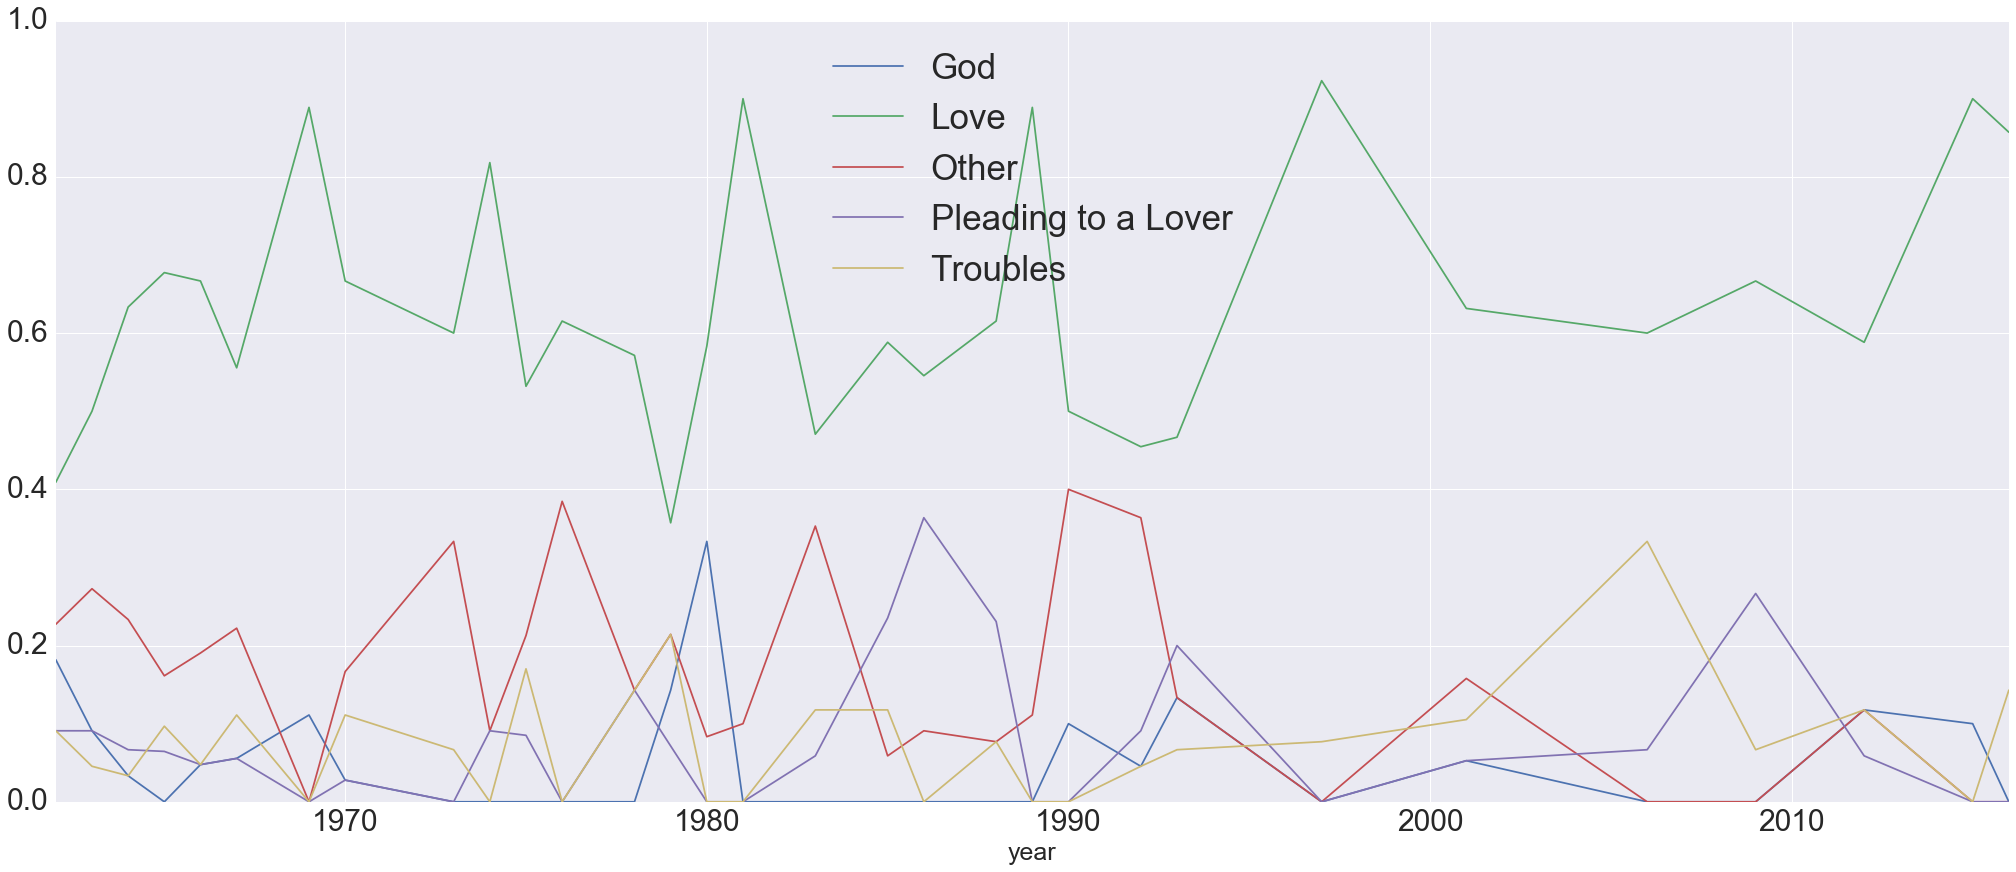

In [142]:
#Start By Plotting Themes all themes across time
by_year[by_year.columns.difference(['other'])].plot()

<b>The theme of love seems to be the one most covered throughout his career both in love lost and gained.<br>
We can see this by the top words he uses in the tfidf matrix

In [145]:
df = pd.DataFrame(tfidf.todense(), columns = [tfidf_feature_names]).describe()
pd.DataFrame(df.loc['mean'].sort_values(ascending = False).head())

,mean
know,0.053485
love,0.053221
got,0.052596
one,0.050351
baby,0.043644


<b> Love and baby are the second and fifth most used words in his songs (after you remove all stopwords)<br>

I was interested in how the data showed his born again Christian part of his life so I plotted the topic of God

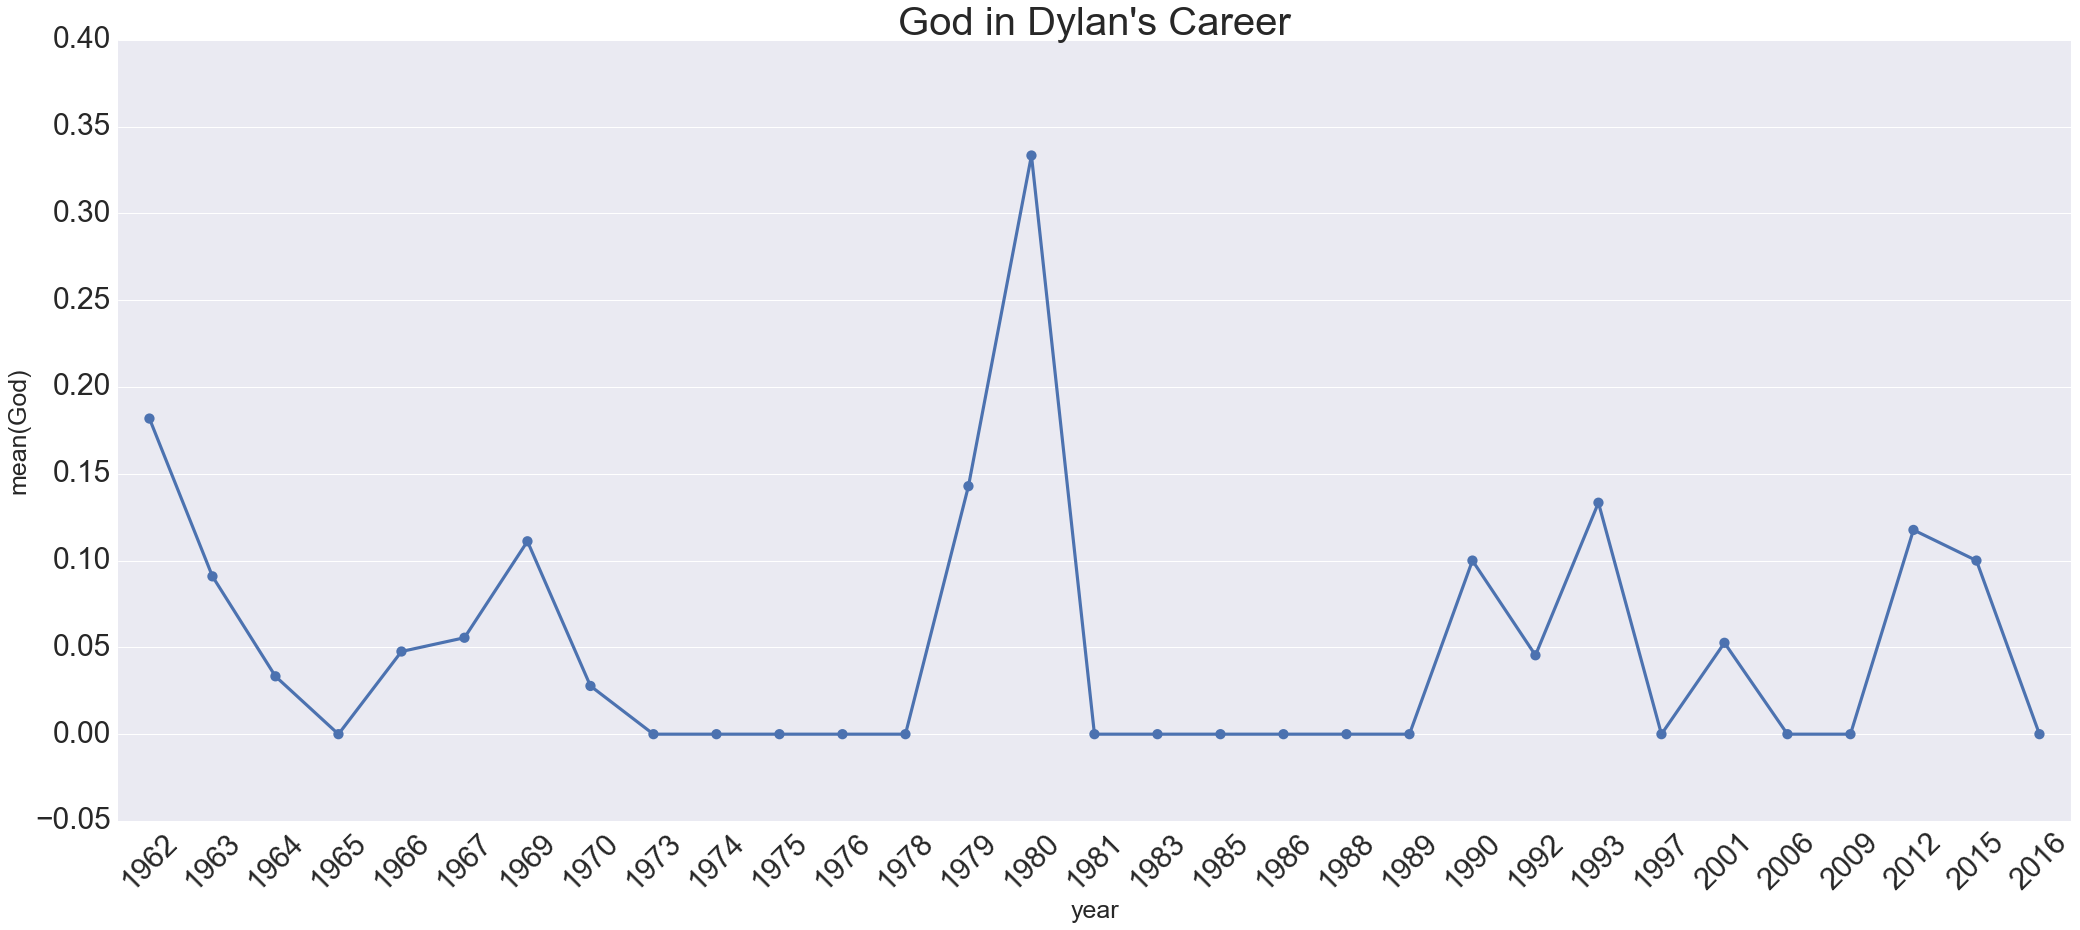

In [150]:
sns.pointplot(x = by_year.index, y = by_year.God)
plt.title("God in Dylan's Career", fontsize = 40)
plt.xticks(rotation = 45)
print ''

<b> We can see a spike in his two albums in 1979 and 1980 which are his religious albums Slow Train Coming and Saved, awesome!

What are some other points?<br></b>
Other points of interest are in the beginning of his career, a peak in 1969 and 1993. In these periods Dylan did mostly covers of traditional folk songs which account for the mention of god.<br><br>

<b>What's interesting is that Dylan covers god in covers of folk songs and when he become Christian himself. And you can see that clearly through the data.

### Let's Talk about Love ;)

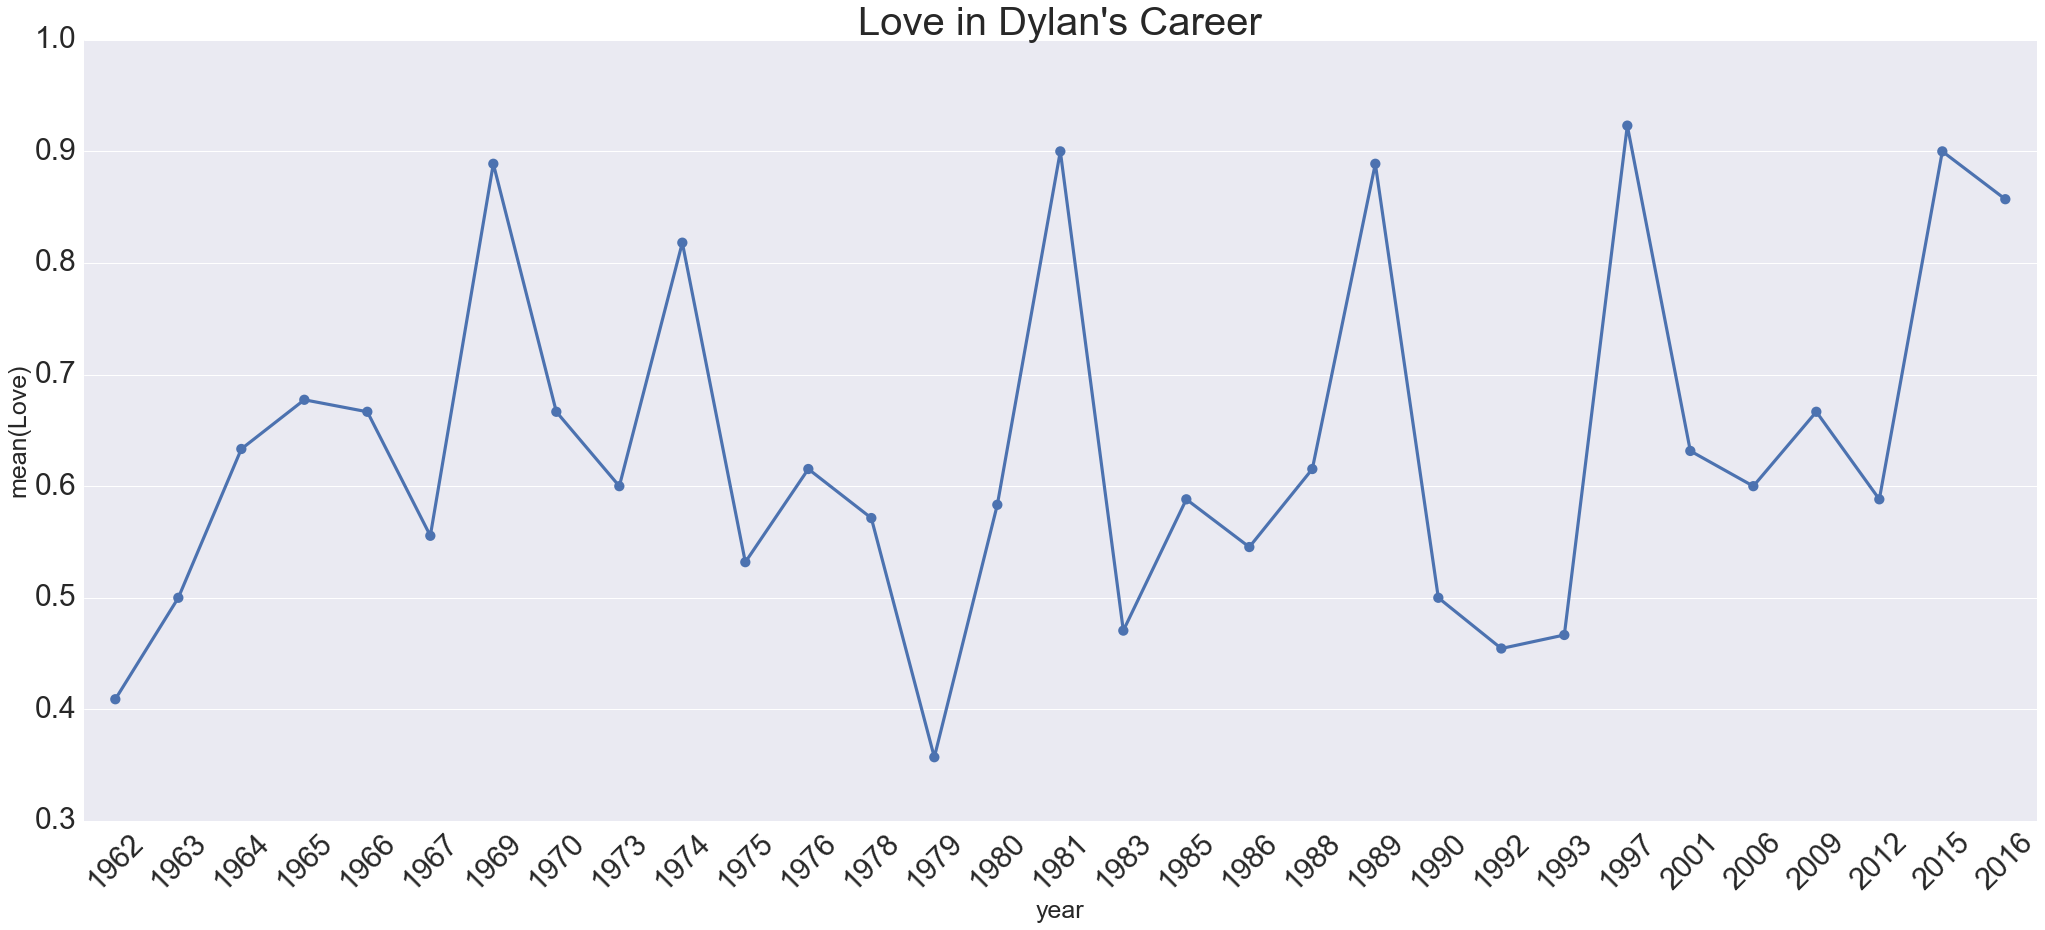

In [162]:
sns.pointplot(x = by_year.index, y = by_year.Love)
plt.title("Love in Dylan's Career", fontsize = 40)
plt.xticks(rotation = 45)
print ''

<b> This graph seems like any person dealing with love throughout their lives, there are high points and very low points. But these peaks are about love both in a negative sense and a positive sense. The lowest point is in 1969 when Dylan starts what becomes the trilogy of his christian albums that ends with a very high point in 1981 with the album called "Shot of Love". <br><br>
The highest point of love in his career is in 1997 when he released Time Out of Mind which is considered his comeback record and has 3 songs that center around the concept of longing and love lost.

## Overall

I know it's surprising to end the analysis so soon but even with using nmf to come up with more topic, the topics are not cut and dry. Dylan's complex metaphors and themes make his songs hard to cluster. When you graph the other two topics that I extracted it becomes increasingly hard to make sense of them. I am basically deriving themes like a rorschach test. I still had fun trying to decipher one of my favorite artist's lyrics.